---
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Berenklauw classificatie</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Teamleden</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://www.hpg-hoveniers.nl/wp-content/uploads/2015/06/berenklauw-bestrijden-1024x768.jpg" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Table of contents </strong></h2>
</div>
<ul style="padding: 0; list-style: none;">
    <li style="text-align: center;"><a href="#1.0">Chapter 1: Packages, data en zelfgedefineerde functie's inladen</a></li>
    <li style="text-align: center;"><a href="#2.0">Chapter 2: Exploratory Data Analysis</a></li>
    <li style="text-align: center;"><a href="#3.0">Chapter 3: Model</a></li>
    <li style="text-align: center;"><a href="#5.0">Chapter 4: Model evaluatie</a></li>
    <li style="text-align: center;"><a href="#6.0">Chapter 5: Eigen data uittesten</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 6: API voor MRR</a></li>
    <li style="text-align: center;"><a href="#8.0">Chapter 7: Bronnenlijst</a></li>
</ul>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 1: Packages, data en zelfgedefineerde functie's inladen </strong></h2>
</div>

### Packages inladen

In [1]:
import os
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import concatenate, UpSampling2D

### Zelfgedefineerde functie's inladen

In [2]:
# Functie om maskers voor te verwerken om binaire waarden te garanderen
def preprocess_mask(mask):
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask

# Functie om pixels met 1 of 0 te tellen
def count_pixels(mask):
    unique, counts = np.unique(mask, return_counts=True)
    pixel_count = dict(zip(unique, counts))
    return pixel_count

# Functie om afbeeldingen weer te geven
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Drempel toepassen op voorspelde maskers voor binaire segmentatie
def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

In [3]:
def split_image(image, patch_size=256):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

def merge_patches(patches, image_shape, patch_size=256):
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, 1))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            patch_h, patch_w, _ = patch.shape
            if i + patch_h > h or j + patch_w > w:
                patch = patch[:h-i, :w-j, :]  # Adjust the patch size to fit the image dimensions
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch
            patch_index += 1
    return reconstructed_image

# Laad je eigen afbeelding
def load_single_image(image_path, target_size=None):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    return image

In [4]:
def plot_loss(history):
    """
    Deze functie laat twee grafieken zien. De eerste toont de loss tijdens training en validatie over de epochs. 
    De tweede toont de IoU tijdens training en validatie over de epochs.

    Parameters:
        history: Dit is het object dat wordt teruggegeven door de `fit` methode van een Keras model.

    Returns:
        None
    """
    plt.figure(figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation Losses', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], color='lightgray', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['IoU'], label='Training IoU', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_IoU'], label='Validation IoU', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation IoU', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('IoU', fontsize=14)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['IoU'])), history.history['IoU'], history.history['val_IoU'], color='lightgray', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [5]:
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [6]:
# Functie om alleen de input en de voorspelde maskers weer te geven
def display_prediction_images(input_image, predicted_mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

#### Hier knippen we de data op in allemaal kleine afbeeldingen van 256x256, zodat we meer data beschikbaar hebben en de foto's niet te groot zijn om inteladen

```python

def split_and_save_images(image_dir, output_dir, patch_size=256):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_names = os.listdir(image_dir)

    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            width, height = image.size

            num_patches_x = width // patch_size
            num_patches_y = height // patch_size

            for i in range(num_patches_x):
                for j in range(num_patches_y):
                    left = i * patch_size
                    upper = j * patch_size
                    right = (i + 1) * patch_size
                    lower = (j + 1) * patch_size
                    
                    patch = image.crop((left, upper, right, lower))
                    patch_name = f"{file_name.split('.')[0]}_patch_{i}_{j}.jpg"
                    patch.save(os.path.join(output_dir, patch_name))

image_dir = 'eigen masks/images'
output_dir = 'eigen masks/image_patches'
split_and_save_images(image_dir, output_dir)

mask_dir = 'eigen masks/masks'
output_dir = 'eigen masks/mask_patches'
split_and_save_images(mask_dir, output_dir)

### Afbeeldingen en masks inladen

Total images: 8802
Steps per epoch: 137
Validation steps: 27.0


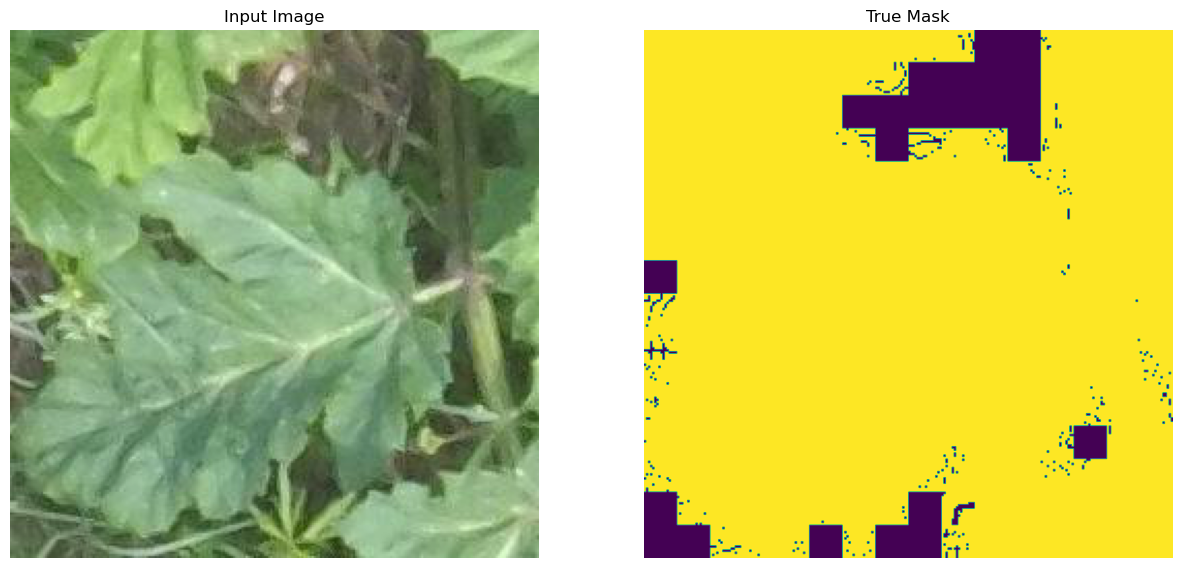

In [7]:
def batch_generator(image_folder, mask_folder, batch_size):
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)
    while True:
        batch_images = []
        batch_masks = []
        for i in range(batch_size):
            img_file = image_files[i % len(image_files)]
            mask_file = mask_files[i % len(mask_files)]
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)

            image = load_img(img_path, target_size=(256, 256))
            mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")

            image = img_to_array(image) / 255.0
            mask = img_to_array(mask)
            mask = preprocess_mask(mask)

            batch_images.append(image)
            batch_masks.append(mask)

        yield np.array(batch_images), np.array(batch_masks)

image_folder = 'zelf gelabelde data/image_patches'
mask_folder = 'zelf gelabelde data/mask_patches'
batch_size = 64
total_images = len(os.listdir(image_folder))
total_masks = len(os.listdir(mask_folder))

# Bereken steps_per_epoch en validation_steps
steps_per_epoch = total_images // batch_size
validation_steps = (total_images * 0.2) // batch_size

print(f"Total images: {total_images}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

generator = batch_generator(image_folder, mask_folder, batch_size=batch_size)
batch_images, batch_masks = next(generator)
train_images, test_images, train_masks, test_masks = train_test_split(batch_images, batch_masks, test_size=0.2, random_state=42)

# Voorbeeldweergave van een afbeelding en masker
sample_image, sample_mask = train_images[7], train_masks[7]
display_list = [sample_image, sample_mask]
display_images(display_list)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 2: Exploratory Data Analysis </strong></h2>
</div>

In [8]:
num_images_without_masks = sum(np.all(mask == 0) for mask in train_masks)
percentage_without_masks = num_images_without_masks / len(train_masks) * 100

print(f"Aantal afbeeldingen in de dataset: {len(train_masks)}")
print(f"Aantal afbeeldingen met maskers: {len(train_masks) - num_images_without_masks}")
print(f"Aantal afbeeldingen zonder maskers: {num_images_without_masks}")
print(f"Percentage afbeeldingen met maskers: {100 - round(percentage_without_masks, 2)}%")
print(f"Percentage afbeeldingen zonder maskers: {round(percentage_without_masks, 2)}%")

NameError: name 'train_masks' is not defined

In [ ]:
print(f"Afbeelding lengte en breedte: {images[0].shape}")

In [ ]:
data = []

for i in range(len(images)):
    height, width, channels = images[i].shape
    size = height * width
    has_mask = np.any(masks[i])
    mask_coverage = np.sum(masks[i]) / size
    aspect_ratio = width / height
    avg_color = np.mean(images[i], axis=(0, 1)) / 255  
    avg_color_hex = mcolors.rgb2hex(avg_color)
    
    color_std = np.std(images[i], axis=(0, 1)) / 255
    brightness = np.mean(images[i]) / 255
    gray_image = rgb2gray(images[i])
    contrast = np.std(gray_image)

    data.append([i, width, height, size, has_mask, mask_coverage, avg_color, avg_color_hex, color_std, brightness, contrast])

images_info = pd.DataFrame(data, columns=['image_id', 'Breedte', 'Hoogte', 'Grootte'
                                          , 'Heeft een mask', 'Mask bedekking', 'Verdeling kleuren'
                                          , 'Gemiddelde kleur HTML', 'Kleurvariatie', 'Helderheid'
                                          , 'Contrast'])

images_info.head(10)

 1.⁠ ⁠⁠ image_id ⁠: Dit is een unieke identificatie voor elke afbeelding in de dataset. In dit geval is het de index van de afbeelding in de lijst ⁠ images ⁠. Bijvoorbeeld, ⁠ 0 ⁠ betekent dat dit de eerste afbeelding in de lijst is. Het is belangrijk om elke afbeelding te kunnen identificeren, vooral als je later naar specifieke afbeeldingen wilt verwijzen.

 2.⁠ ⁠⁠ Breedte ⁠: Dit is de breedte van de afbeelding in pixels. In dit geval is de breedte ⁠ 224 ⁠ pixels. Het kennen van de afmetingen van de afbeelding kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

 3.⁠ ⁠⁠ Hoogte ⁠: Dit is de hoogte van de afbeelding in pixels. In dit geval is de hoogte ⁠ 224 ⁠ pixels. Net als de breedte kan de hoogte nuttig zijn bij het analyseren van de afbeelding.

 4.⁠ ⁠⁠ Grootte ⁠: Dit is het totale aantal pixels in de afbeelding, berekend als breedte x hoogte. In dit geval is de grootte ⁠ 50176 ⁠ pixels. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

 5.⁠ ⁠⁠ Heeft een mask ⁠: Dit geeft aan of de afbeelding een bijbehorend masker heeft. In dit geval heeft de afbeelding geen masker (⁠ False ⁠). Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de aanwezigheid van een masker de andere kenmerken van de afbeelding beïnvloedt.

 6.⁠ ⁠⁠ Mask bedekking ⁠: Dit is het percentage van de afbeelding dat wordt bedekt door het masker, berekend als het aantal maskerpixels gedeeld door het totale aantal pixels. In dit geval is de maskerdekking ⁠ 0.000000 ⁠, wat betekent dat er geen masker is. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de maskerdekking de andere kenmerken van de afbeelding beïnvloedt.

 7.⁠ ⁠⁠ Verdeling kleuren ⁠: Dit is de gemiddelde kleur van de afbeelding, berekend als de gemiddelde RGB-waarde van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de gemiddelde kleur ⁠ [0.3177765, 0.31320137, 0.20988709] ⁠, wat een donkerbruine kleur is. Het kennen van de gemiddelde kleur kan nuttig zijn bij het analyseren van de afbeelding, zodat je weet hoe verschillend de kleuren zijn.

 8.⁠ ⁠⁠ Gemiddelde kleur HTML ⁠: Dit is de gemiddelde kleur van de afbeelding, omgezet naar een HTML-kleur (hexadecimale kleurcode). In dit geval is de gemiddelde kleur ⁠ #515036 ⁠, wat overeenkomt met de RGB-kleur in de 'Verdeling kleuren' kolom. Het kennen van de HTML-kleur kan nuttig zijn voor visualisatiedoeleinden, bijvoorbeeld om een overzicht van de gemiddelde kleuren van de afbeeldingen te maken.

 9.⁠ ⁠⁠ Kleurvariatie ⁠: Dit is de standaardafwijking van de kleuren in de afbeelding, berekend als de standaardafwijking van de RGB-waarden van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de kleurvariatie ⁠ [0.18607375, 0.18607375, 0.18607375] ⁠, wat betekent dat de kleuren in de afbeelding niet erg variëren. Het kennen van de kleurvariatie kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe uniform de kleuren zijn.

10.⁠ ⁠⁠ Helderheid ⁠: Dit is de gemiddelde helderheid van de afbeelding, berekend als de gemiddelde helderheid van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de helderheid ⁠ 0.31320137 ⁠, wat betekent dat de afbeelding niet erg helder is. Het kennen van de helderheid kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe licht of donker de afbeelding is.

11.⁠ ⁠⁠ Contrast ⁠: Dit is de contrastwaarde van de afbeelding, berekend als de standaardafwijking van de grijswaarden van de afbeelding. In dit geval is het contrast ⁠ 0.18607375 ⁠, wat betekent dat de afbeelding een gemiddeld contrast heeft. Het kennen van het contrast kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe scherp de overgangen tussen lichte en donkere delen zijn.

In [ ]:
images_info[['Kleurvariatie', 'Helderheid', 'Contrast']].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(images_info['Mask bedekking'], bins=50)
plt.xlabel('Mask Coverage')
plt.ylabel('Count')
plt.title('Distribution of mask coverage')
plt.show()

We zien dat er veel afbeeldingen zijn zonder of weinig maskers. Dit is dan moeilijk voor het model om te leren. 
Wel is dit nodig, omdat we kunnen zien dat het model ook werkt als er geen berenklauw te zien is. 
Zoals eerder is aangegeven is 17% van de afbeeldingen zonder masker. Dit is een prima percentage om mee te werken, omdat het model ook moet leren om afbeeldingen zonder masker te herkennen meestal afbeeldingen zijn zonder berenklauwen.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 3: Model </strong></h2>
</div>

### Encoder en Decoder

In [8]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])
    
    return model

model = unet_model(input_size=(256, 256, 3))
model.summary()

2024-05-19 18:45:34.385254: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-19 18:45:34.385282: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-19 18:45:34.385287: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-19 18:45:34.385512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 18:45:34.385530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Data Augmentation

In [9]:
# Data augmentatie instellen
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Gebruik dezelfde zaden voor reproductie
seed = 1
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(train_masks, batch_size=batch_size, seed=seed)

train_generator = zip(image_generator, mask_generator)

### Model trainen

In [10]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, validation_data=(test_images, test_masks), validation_steps=validation_steps)

Epoch 1/5


2024-05-19 18:45:39.932960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


137/137 [==============================] - ETA: 0s - loss: 1.6658 - iou: 0.2117

2024-05-19 19:01:35.754380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-19 19:01:36.365570: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4693324533050937437
2024-05-19 19:01:36.365584: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8972006841797106115
2024-05-19 19:01:36.365588: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4533387625879813279
2024-05-19 19:01:36.365592: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16162672197312445877
2024-05-19 19:01:36.365596: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13234854504276821731
2024-05-19 19:01:36.365620: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous 

137/137 [==============================] - 957s 7s/step - loss: 1.6658 - iou: 0.2117 - val_loss: 0.3295 - val_iou: 0.0674
Epoch 2/5
137/137 [==============================] - 919s 7s/step - loss: 0.2654 - iou: 0.3540
Epoch 3/5
137/137 [==============================] - 916s 7s/step - loss: 0.1653 - iou: 0.5523
Epoch 4/5
137/137 [==============================] - 918s 7s/step - loss: 0.1072 - iou: 0.7002
Epoch 5/5
137/137 [==============================] - 920s 7s/step - loss: 0.0674 - iou: 0.8033


### Model opslaan

In [12]:
#model.save('berenklauw_model.keras')

In [ ]:
#model.save('berenklauw_model.h5')

### Model inladen

In [ ]:
#new_model = tf.keras.models.load_model('berenklauw_model.h5')

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 4: Model evaluatie </strong></h2>
</div>

In [ ]:
plot_loss(history)

2024-05-19 21:59:57.690814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 536ms/step


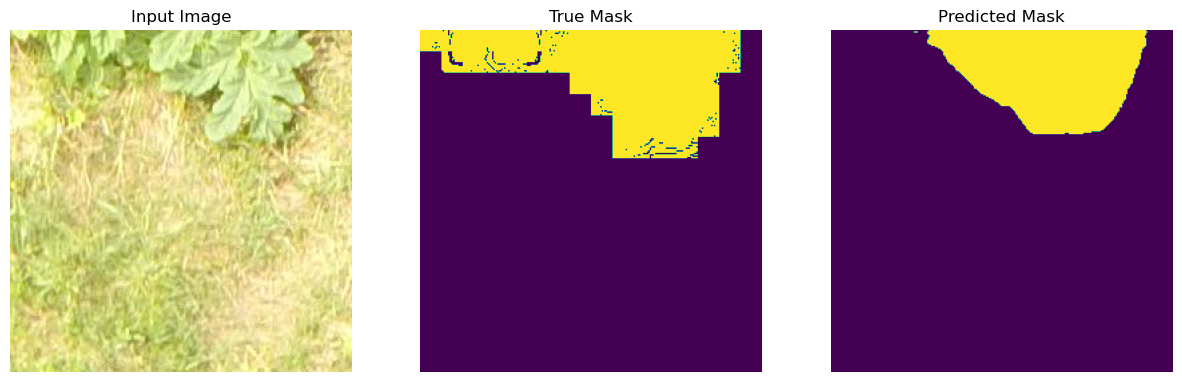

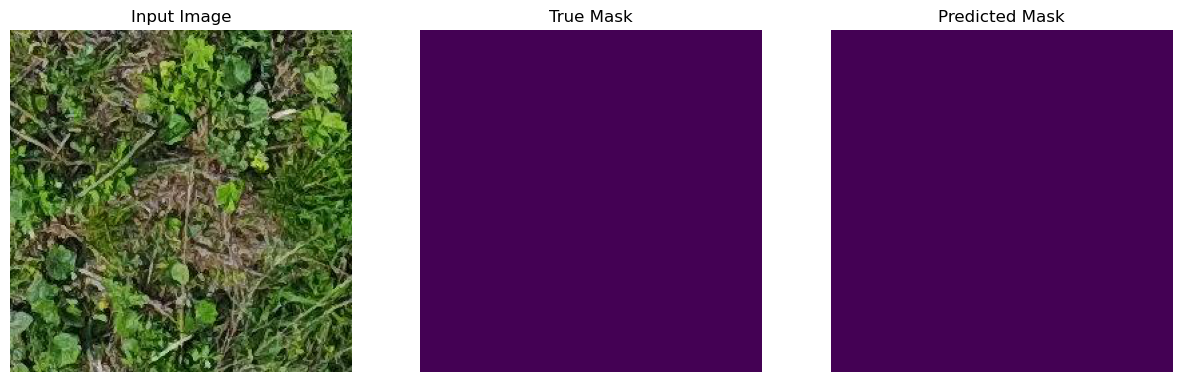

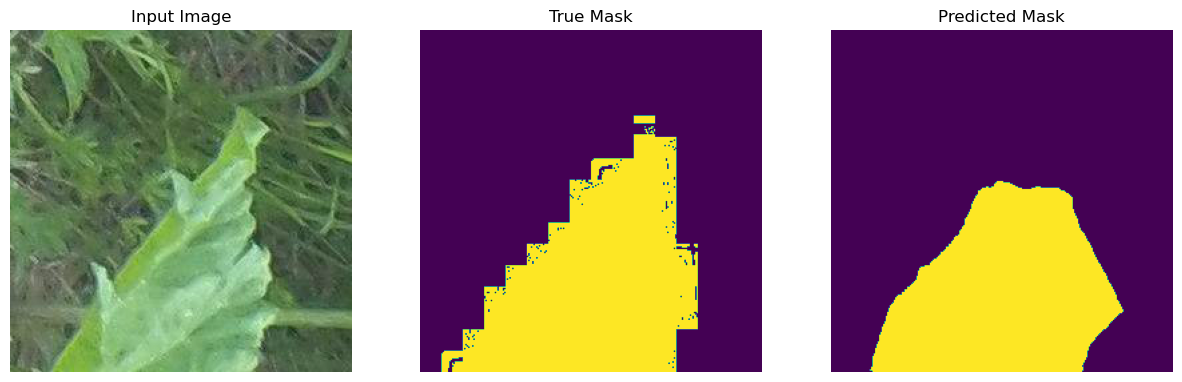

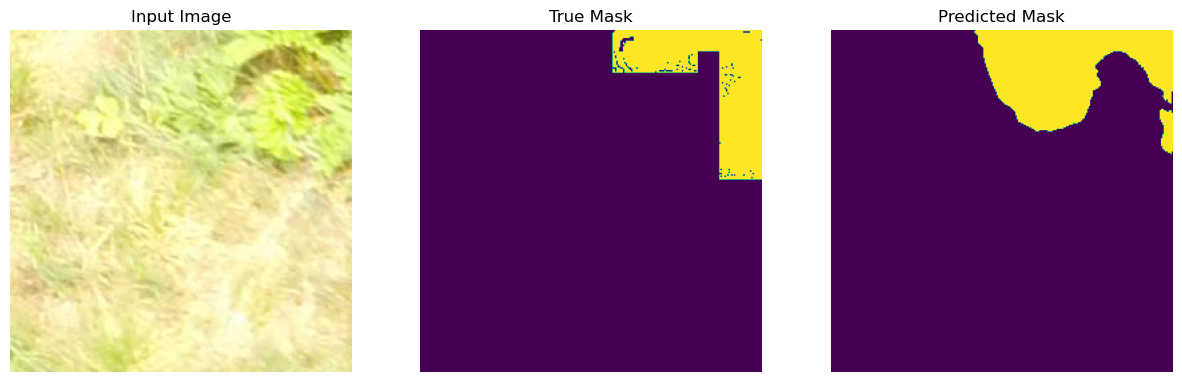

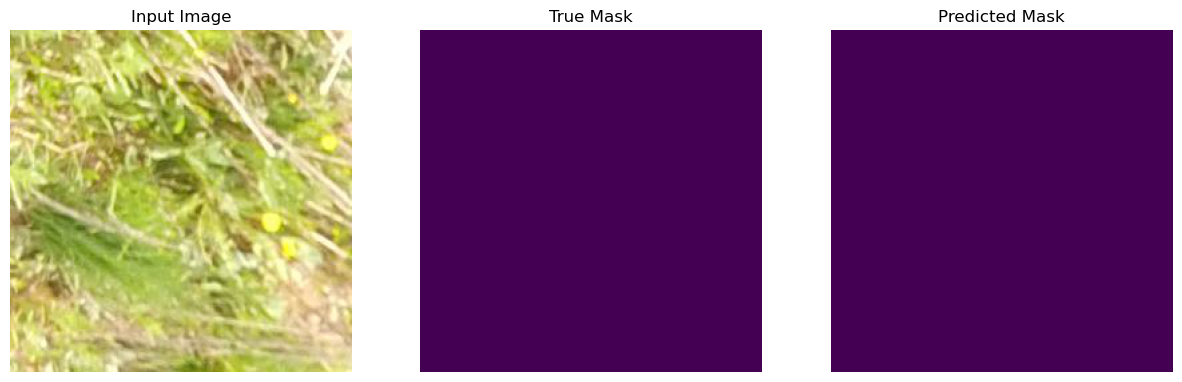

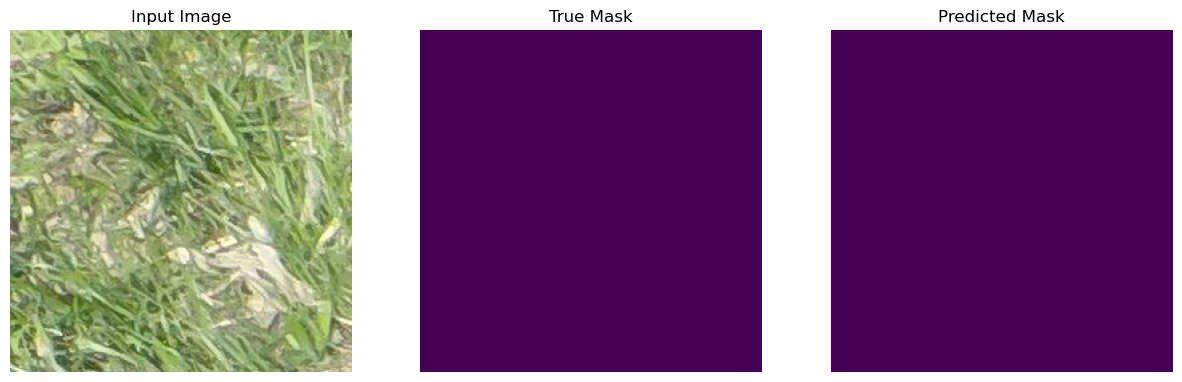

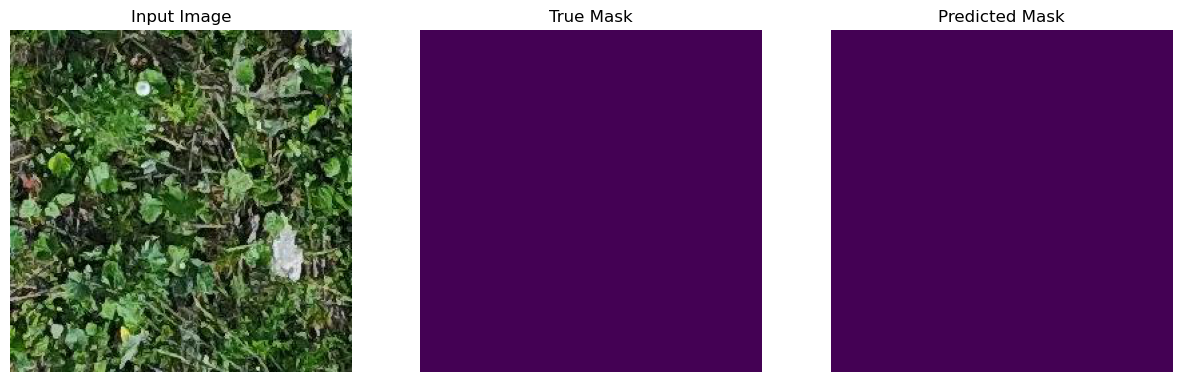

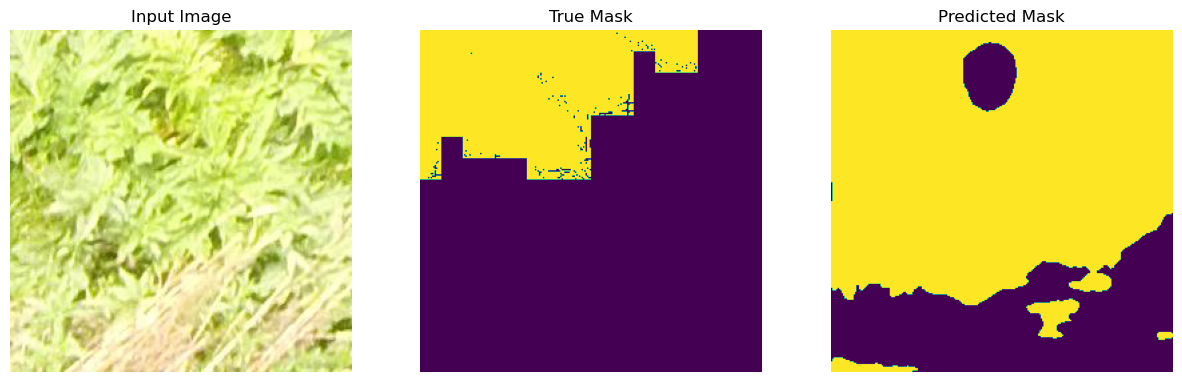

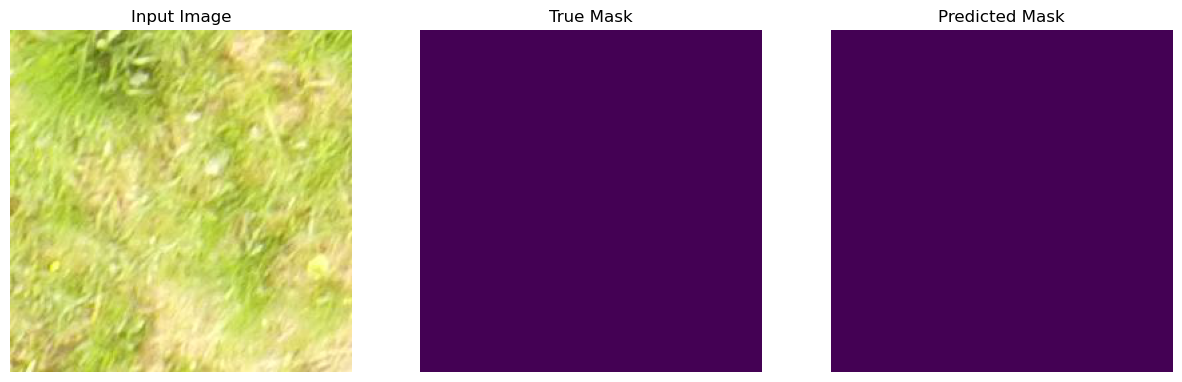

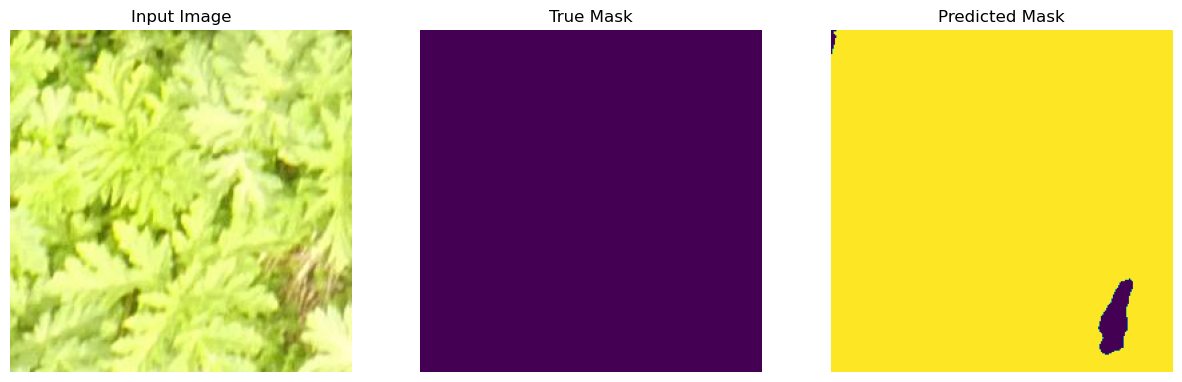

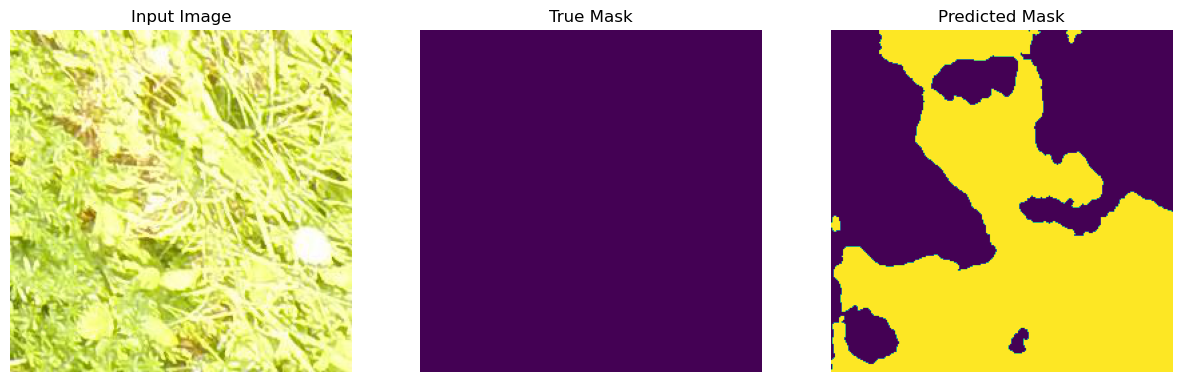

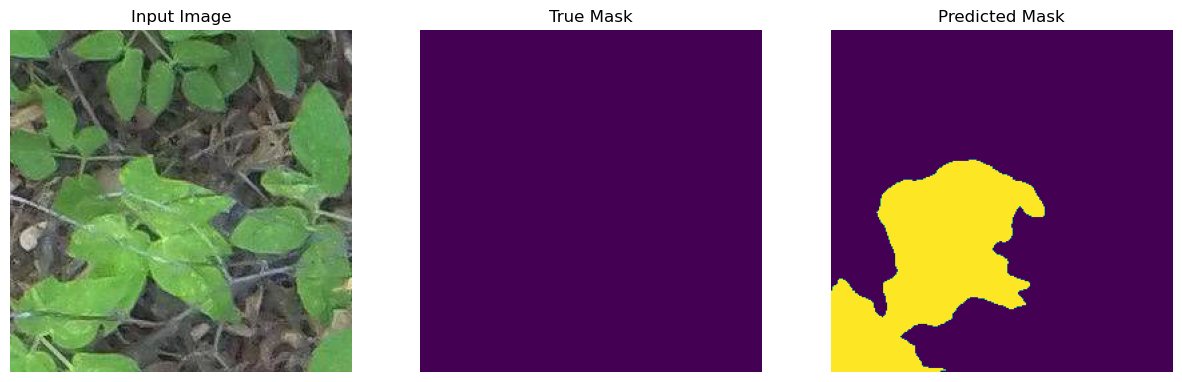

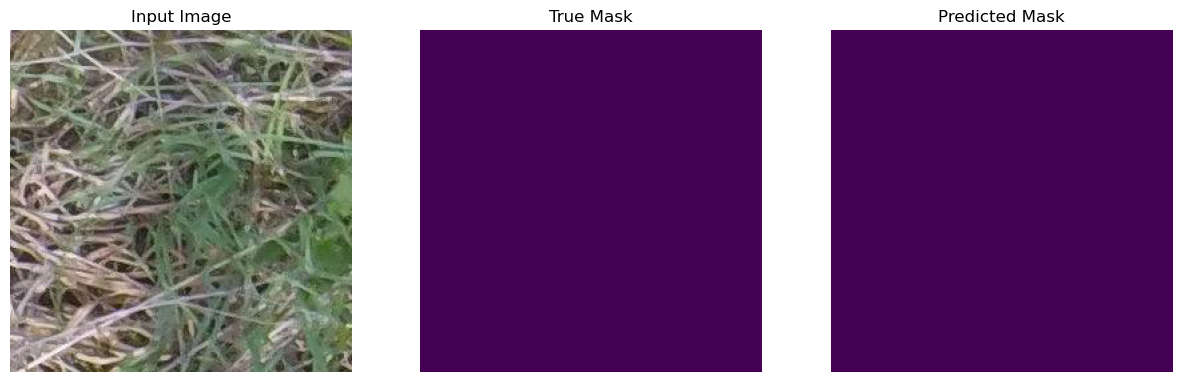

In [11]:
pred_masks = model.predict(test_images)
pred_masks_thresholded = threshold_predictions(pred_masks, threshold=0.5)

for i in range(len(test_images)):
    display_images([test_images[i], test_masks[i], pred_masks_thresholded[i]])

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 5: Eigen data uittesten </strong></h2>
</div>

/Users/vince/tensorflow-env/tensorflow/lib/python3.8/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


53/53 [==============================] - 57s 1s/step


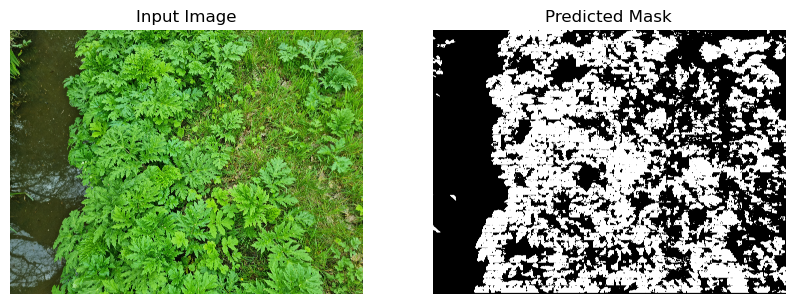

In [14]:
# Afbeelding inladen
own_image_path = 'eigen data/20240408_133531.jpg'
own_image = load_single_image(own_image_path, target_size=None) 

# Snijd de afbeelding in stukken van 256x256
patches = split_image(own_image, patch_size=256)

# Voer voorspellingen uit voor elk stuk
patches_array = np.array(patches)
pred_patches = model.predict(patches_array)
pred_patches_thresholded = threshold_predictions(pred_patches, threshold=0.5)

# Voeg de voorspelde stukken samen tot één volledige afbeelding
reconstructed_mask = merge_patches(pred_patches_thresholded, own_image.shape, patch_size=256)

display_prediction_images(own_image, reconstructed_mask)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 6: API voor MRR </strong></h2>
</div>

url = 'http://127.0.0.1:8000/predict/'
file_path = 'eigen data/IMG_4490.jpeg'

with open(file_path, 'rb') as f:
    response = requests.post(url, files={'file': f})

print(f"Status code: {response.status_code}")
print(f"Response text: {response.text}")

try:    
    json_response = response.json()
    print(json_response)
except ValueError as e:
    print("Error parsing JSON response:", e)

In [ ]:
url = 'http://127.0.0.1:8000/predict/'
file_path = 'eigen data/IMG_4490.jpeg'

with open(file_path, 'rb') as f:
    response = requests.post(url, files={'file': f})

print(f"Status code: {response.status_code}")

try:
    json_response = response.json()
    print(f"Size of JSON response: {len(response.text)} characters")

    prediction = np.array(json_response['prediction'])

    # Visualiseer de originele afbeelding
    original_image = plt.imread(file_path)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    # Visualiseer voorspelde mask
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()
except ValueError as e:
    print("Error parsing JSON response:", e)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 7: Bronnenlijst </strong></h2>
</div>

- _GeeksforGeeks. (2022, 1 augustus). Image segmentation using TensorFlow. GeeksforGeeks._ https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/